In [11]:
!pip install -U scikit-learn scipy matplotlib

     ---------------------------------------- 9.2/9.2 MB 59.2 MB/s eta 0:00:00
     --------------------------------------- 44.0/44.0 MB 81.8 MB/s eta 0:00:00
     ---------------------------------------- 302.0/302.0 kB ? eta 0:00:00



[notice] A new release of pip available: 22.2.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('./spotify_data.csv')

In [3]:
m = df['popularity'].quantile(0.99)
songs = df.copy().loc[df['popularity'] >= m]
songs = songs.sort_values('popularity', ascending=False)

In [4]:
songs = songs.drop(columns=["Unnamed: 0", "year", "duration_ms"])

In [5]:
songs.head()

,artist_name,track_name,track_id,popularity,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
612503,Miley Cyrus,Flowers,0yLdNVWF3Srea0uzk55zFn,100,pop,0.707,0.681,0,-4.325,1,0.0668,0.0632,0.000005,0.0322,0.646,117.999,4
605178,Bizarrap,"Shakira: Bzrp Music Sessions, Vol. 53",4nrPB8O7Y7wsOCJdgXkthe,96,hip-hop,0.778,0.632,2,-5.600,0,0.0493,0.2740,0.000000,0.0915,0.498,122.104,4
612504,The Weeknd,Die For You - Remix,7oDd86yk8itslrA9HRP2ki,95,pop,0.531,0.525,1,-6.500,0,0.0671,0.2320,0.000000,0.4410,0.502,66.900,4
569184,SZA,Kill Bill,1Qrg8KqiBpW07V7PNxwwwL,94,pop,0.644,0.735,8,-5.747,1,0.0391,0.0521,0.144000,0.1610,0.418,88.980,4
569195,Manuel Turizo,La Bachata,5ww2BF9slyYgNOk37BlC4u,93,pop,0.835,0.679,7,-5.329,0,0.0364,0.5830,0.000002,0.2180,0.850,124.980,4


In [6]:
tempSongsDF = songs.drop(columns=["track_name", "popularity", "track_id", "artist_name"])

In [7]:
#OHE Genre
onehot_encoded = pd.get_dummies(tempSongsDF['genre'])
tempSongsDF = pd.concat([tempSongsDF, onehot_encoded], axis=1)
tempSongsDF.drop('genre', axis=1, inplace=True)

In [8]:
#OHE Key
onehot_encoded = pd.get_dummies(tempSongsDF['key'], prefix='key')
tempSongsDF = pd.concat([tempSongsDF, onehot_encoded], axis=1)
tempSongsDF.drop('key', axis=1, inplace=True)

In [9]:
#Z score normalizing Tempo
mean_tempo = tempSongsDF['tempo'].mean()
std_tempo = tempSongsDF['tempo'].std()
tempSongsDF['tempo_zscore'] = (tempSongsDF['tempo'] - mean_tempo) / std_tempo
tempSongsDF.drop('tempo', axis=1, inplace=True)

In [10]:
#Minmax normalizing loudness
# Clip values less than -20 to -20 in the "loudness" column
tempSongsDF['loudness'] = tempSongsDF['loudness'].clip(lower=-20)

# Calculate the minimum and maximum values of the "loudness" column
min_loudness = tempSongsDF['loudness'].min()
max_loudness = tempSongsDF['loudness'].max()

# Perform Min-Max scaling on the "loudness" column
tempSongsDF['loudness_minmax'] = (tempSongsDF['loudness'] - min_loudness) / (max_loudness - min_loudness)
tempSongsDF.drop('loudness', axis=1, inplace=True)

In [ ]:
#Label Encoding
#This is probably not preferable since numbers imply that some genres are more similar to others.
#Holy fuck label encoding sucks do not use.
#from sklearn.preprocessing import LabelEncoder

#label_encoder = LabelEncoder()
#tempSongsDF['genre_encoded'] = label_encoder.fit_transform(tempSongsDF['genre'])
#tempSongsDF.drop('genre', axis=1, inplace=True)

In [27]:
#COSINE Distances
from sklearn.metrics.pairwise import manhattan_distances

cs = manhattan_distances(tempSongsDF)
print(cs)

[[ 0.          5.7562062   5.91157392 ...  5.27068529  8.06556507
   6.20323713]
 [ 5.7562062   0.          6.7065222  ...  6.52649149  8.45136916
   5.57879571]
 [ 5.91157392  6.7065222   0.         ...  5.25651023 10.05485775
   5.83099709]
 ...
 [ 5.27068529  6.52649149  5.25651023 ...  0.          8.48543865
   5.97876174]
 [ 8.06556507  8.45136916 10.05485775 ...  8.48543865  0.
   9.50859623]
 [ 6.20323713  5.57879571  5.83099709 ...  5.97876174  9.50859623
   0.        ]]


In [28]:
songs_ids = pd.Series(range(songs['track_id'].size), index=songs['track_id'])
songs_ids

track_id
0yLdNVWF3Srea0uzk55zFn        0
4nrPB8O7Y7wsOCJdgXkthe        1
7oDd86yk8itslrA9HRP2ki        2
1Qrg8KqiBpW07V7PNxwwwL        3
5ww2BF9slyYgNOk37BlC4u        4
                          ...  
6SG8lh7fWQ2bahP5WBYePn    12044
5XS0GCCIotaI6XtsYcIKeX    12045
28xjm4FnnGI4Xnds7VoNSl    12046
3HBNf1kBZB3Sn4idl26aJK    12047
4NDpn6yfD5aqafYWFEaJDz    12048
Length: 12049, dtype: int64

In [29]:
def song_recommender(song_id, cs=cs):
    idx = songs_ids[song_id]
    scores = list(enumerate(cs[idx]))
    sorted_scores = sorted(scores, key= lambda x:x[1], reverse=False)[1:11]
    rec_songs_idxs = [i[0] for i in sorted_scores]
    print("\nTop 10 similar songs:\n")
    return songs.iloc[rec_songs_idxs]

In [30]:
def getSongId(song_name, artist_name=""):
    if artist_name == "":
        ids = songs[songs["track_name"] == song_name]['track_id']
        if ids.size > 1:
            raise Exception("Provide artist name, song appears multiple times.")
        else:
            return ids.iloc[0]
    else:
        ids = songs[songs["track_name"] == song_name]
        ids = ids[ids["artist_name"] == artist_name]['track_id']
        return ids.iloc[0]

In [31]:
def song_recommender_name(song_name, artist_name=""):
    return song_recommender(getSongId(song_name, artist_name=artist_name))

In [32]:
my_df = song_recommender_name("Hype Boy")


Top 10 similar songs:



In [33]:
my_df

,artist_name,track_name,track_id,popularity,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
247531,BLACKPINK,PLAYING WITH FIRE,7qmvLmX9tyaTiBAVNI6YEn,74,k-pop,0.706,0.756,4,-4.405,0,0.0845,0.03920,0.000000,0.1800,0.676,97.098,4
608245,TWICE,GOT THE THRILLS,1RVsbqAP1WFFXPiBXQYIah,70,k-pop,0.712,0.924,4,-1.549,0,0.1210,0.21000,0.000000,0.2020,0.730,122.037,4
564226,Stray Kids,SUPER BOARD,078fJxqEUz0LvbHSM6AoXJ,65,k-pop,0.751,0.870,4,-2.551,0,0.0713,0.00653,0.000000,0.0770,0.412,103.019,4
564246,NCT DREAM,Beatbox,0CatzXH85XWyBqqdB6qPMB,69,k-pop,0.857,0.700,4,-4.189,0,0.0740,0.04110,0.000000,0.0334,0.773,93.997,4
456873,(G)I-DLE,Oh my god,2DmRXiyn03tOqKgEJXlaiJ,68,k-pop,0.794,0.762,4,-3.525,0,0.0392,0.03580,0.000001,0.1910,0.482,109.970,4
608280,STAYC,Poppy (Korean Ver.),7a86ARVnm366v2UY1z9Ak8,63,k-pop,0.808,0.786,4,-3.842,0,0.0375,0.13900,0.000000,0.2660,0.821,126.047,4
456908,Red Velvet - IRENE & SEULGI,Monster,6c1QaQHdDhtFMfUkhueuXK,64,k-pop,0.631,0.748,4,-2.569,0,0.0488,0.21200,0.000000,0.5370,0.351,115.665,4
401166,ATEEZ,WONDERLAND,6k67RdkVjTZj79c1cRz7IQ,66,k-pop,0.572,0.964,4,-1.949,0,0.1230,0.05030,0.000000,0.3720,0.519,129.979,4
564189,tripleS,Generation,1RHTdr5QfviCYI70QPPDJN,68,k-pop,0.644,0.938,4,-2.206,0,0.0496,0.04590,0.000000,0.7770,0.919,119.977,4
564383,NCT DREAM,To My First,7cjojsJwncbiCI0rqOOf9j,62,k-pop,0.661,0.667,4,-3.875,0,0.0398,0.23300,0.000000,0.1050,0.370,77.006,4


In [51]:
import json
from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)


numpyData = {"array": cs}
encodedNumpyData = json.dumps(numpyData, cls=NumpyArrayEncoder)

In [ ]:
encodedNumpyData

In [7]:
songs_ids.to_csv('song_ids.csv', index=True)

In [6]:
songs.to_csv('songs.csv', index=True)

In [18]:
exports = songs[["artist_name", "track_name", "track_id", "year", "genre"]]

In [25]:
exports.to_json(path_or_buf="tracks.json", orient="records")

In [34]:
np.save('manhattan_distances.npy', cs)

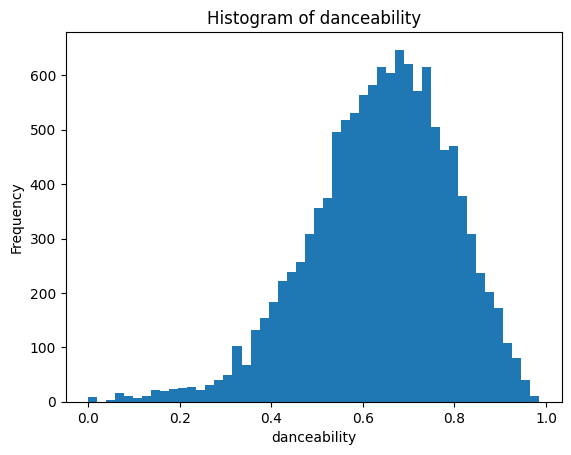

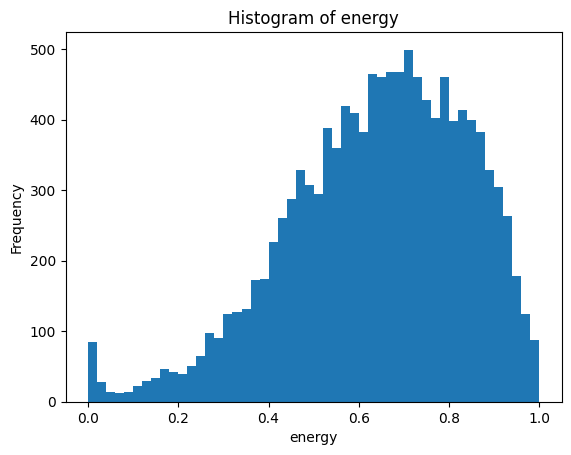

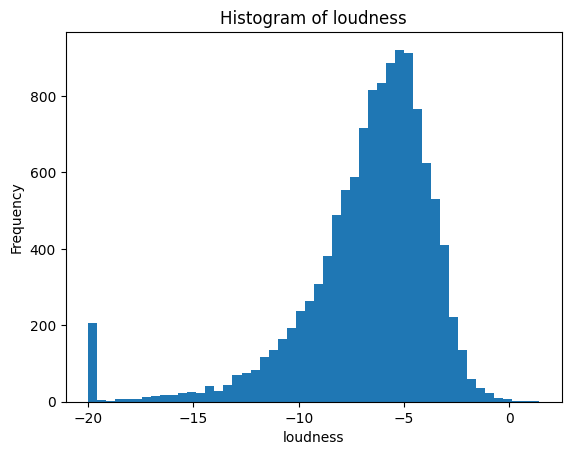

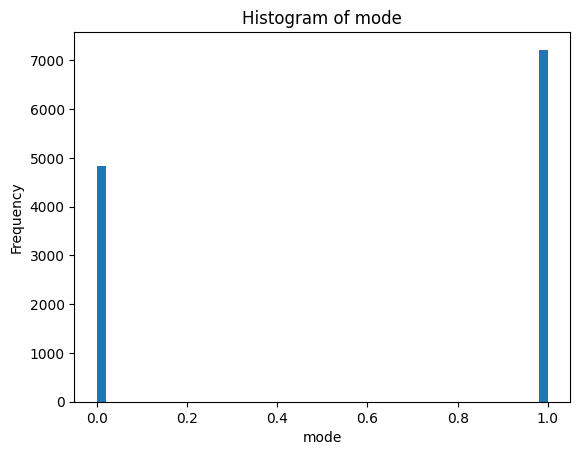

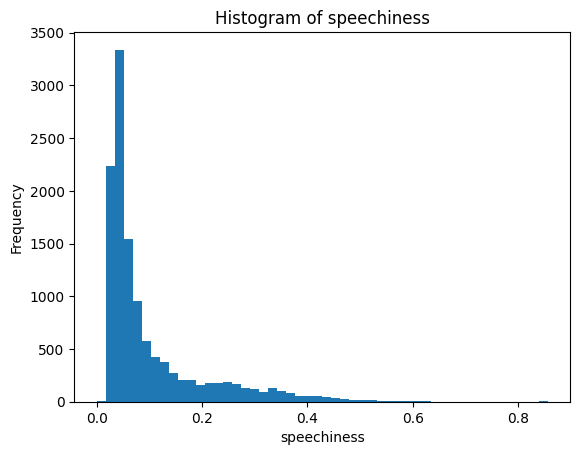

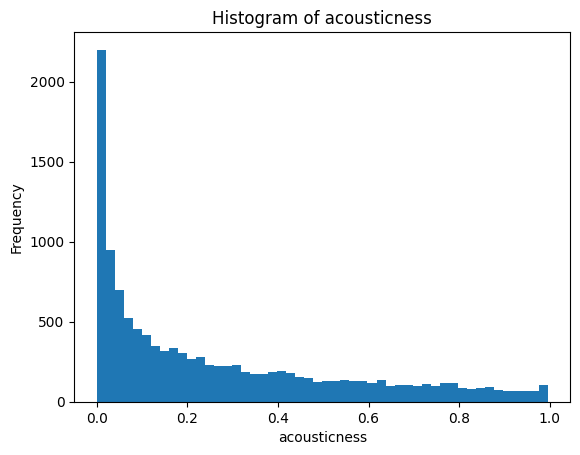

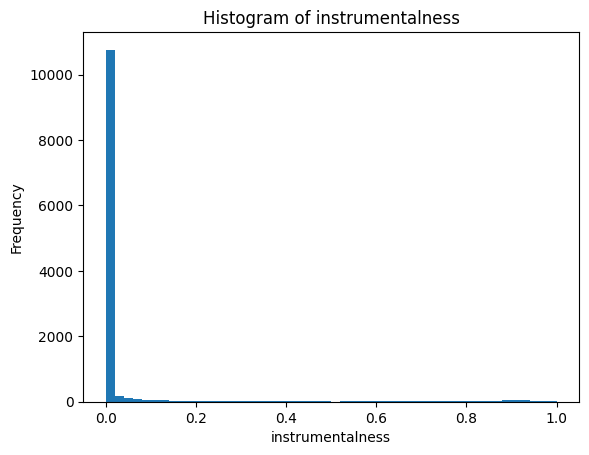

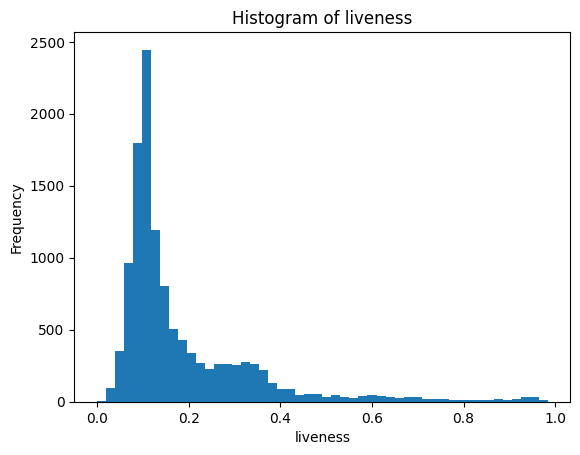

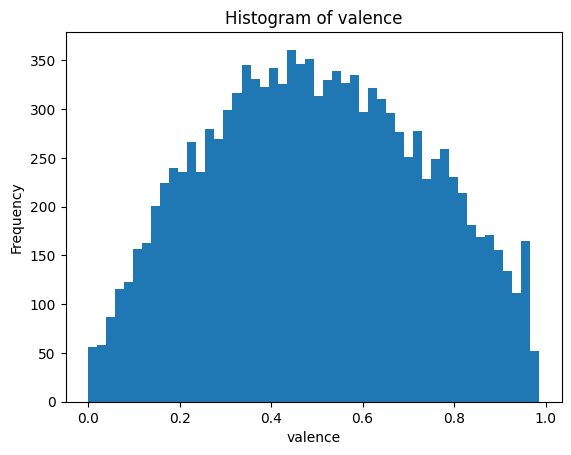

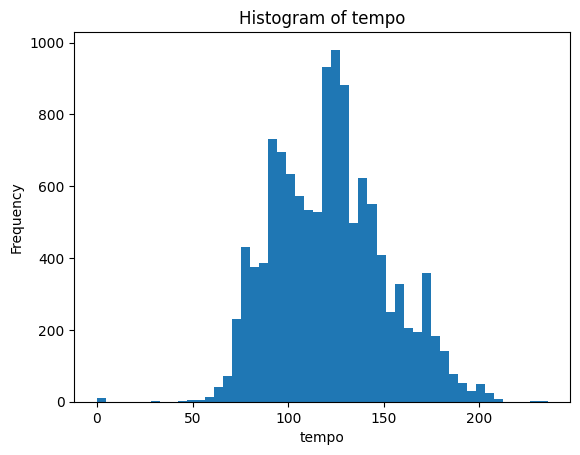

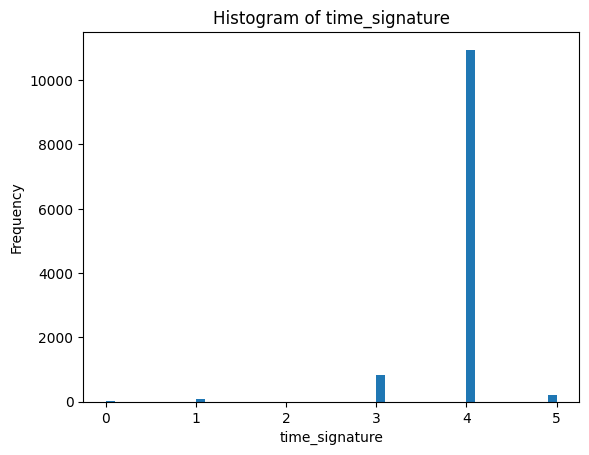

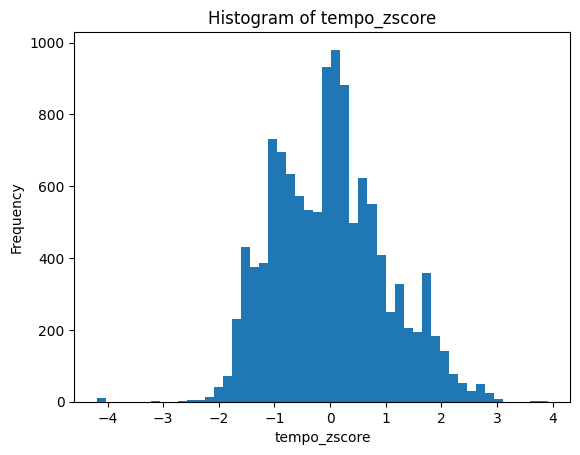

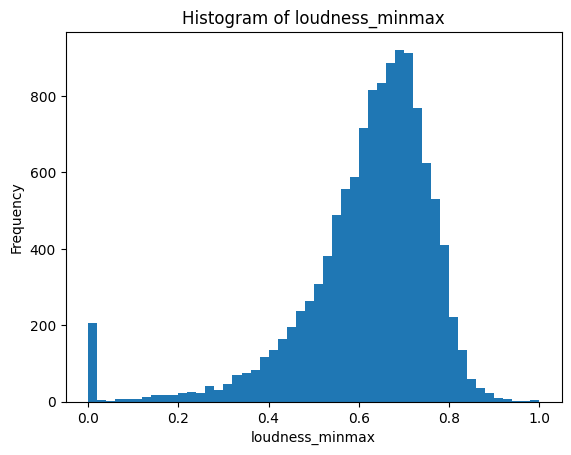

In [91]:
quantitative_columns = tempSongsDF.select_dtypes(include=['int64', 'float64']).columns

# Plot histograms for each quantitative column
for column in quantitative_columns:
    plt.figure()
    plt.hist(tempSongsDF[column], bins=50)  # You can adjust the number of bins
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

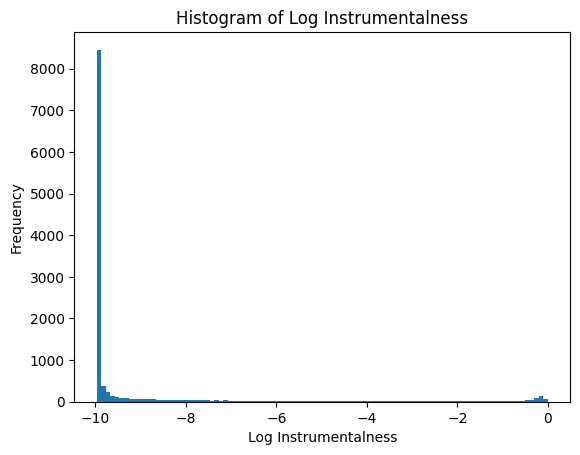

In [70]:
songs['log_instrumentalness'] = np.log2(songs['instrumentalness'] + 0.001)

# Plot the histogram of log speechiness
plt.hist(songs['log_instrumentalness'], bins=100)  # You can adjust the number of bins
plt.title('Histogram of Log Instrumentalness')
plt.xlabel('Log Instrumentalness')
plt.ylabel('Frequency')
plt.show()